In [1]:
import torch , gc
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
import os

%matplotlib inline

In [2]:
data_path = "painter_data_128"

In [3]:
stats = (0.4087, 0.4134, 0.3884),(0.262, 0.2433, 0.2707)

In [4]:
image_size  = 128
batch_size = 32

In [5]:
train_tfms = T.Compose([T.ToTensor(),T.Normalize(*stats)])
# train dataset
train_ds = ImageFolder(data_path,transform=train_tfms)
# training dataloader
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,pin_memory=True,num_workers=3)

In [6]:
# Function for denormalisation before generating
def denorm(img):
    return img*stats[1][0]+stats[0][0]

In [7]:
# GPU USAGE (Jovian)

def get_default_device():
    # Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    # Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        # Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        # Number of batches
        return len(self.dl)


In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
# moving training data to GPU (if availaible)
train_dl = DeviceDataLoader(train_dl,device)

In [10]:
# DISCRIMINATOR
discriminator = nn.Sequential(
    # 3x128x128
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    #64x64x64
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
 

    #128x32x32
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    

    #256x16x16
    nn.Conv2d(256,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.LeakyReLU(0.2,inplace=True),

    #256x8x8
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    #512x4x4
    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),

    #1x1x1
    nn.Flatten(),
    nn.Sigmoid()
)

In [11]:
# moving discriminator to device(gpu or cpu)
discriminator = to_device(discriminator,device)
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [12]:
latent_size = 128

In [13]:
# GENERATOR
generator = nn.Sequential(
    # latentsize x 1x1
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=2,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    #512x4x4
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    #256x8x8
    nn.ConvTranspose2d(256,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.ReLU(True),

    #256x16x16
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(128),

    # nn.ConvTranspose2d(128,128,kernel_size=4,stride=1,padding=1,bias=False),
    # nn.ReLU(True),

    #128x32x32
    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    #64x64x64
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    # nn.BatchNorm2d(3),
    # nn.ReLU(True),
    #3x128x128
    nn.Tanh()
)

In [14]:
#moving generator to device
generator = to_device(generator,device)
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): ReLU(inplace=True)
  (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): ConvTranspose2d(64, 3, kernel_si

In [15]:
# # discriminator training
# def d_train(real_images,opt_d):
#     opt_d.zero_grad()

#     #giving real images
#     real_preds = discriminator(real_images)
#     real_targets = torch.ones(real_images.size(0),1,device=device)
#     real_loss = F.binary_cross_entropy(real_preds,real_targets)
#     real_score = torch.mean(real_preds).item()

#     #generating fake images
#     latent = torch.randn(batch_size,latent_size,1,1,device=device)
#     fake_images = generator(latent)

#     #passing fake image through discriminator
#     fake_targets = torch.zeros(fake_images.size(0),1,device=device)
#     fake_preds = discriminator(fake_images)
#     fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
#     fake_score = torch.mean(fake_preds)

#     # updating weights of discriminator
#     loss = real_loss+fake_loss
#     loss.backward()
#     opt_d.step()

#     return loss.item(),real_score,fake_score

In [16]:
def d_train(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [17]:
# # generator training
# def g_train(opt_g):
#     opt_g.zero_grad()

#     #generate fake image
#     latent = torch.randn(batch_size,latent_size,1,1,device=device)
#     fake_images = generator(latent)

#     #fooling discriminator
#     preds = discriminator(fake_images)
#     targets = torch.ones(batch_size,1,device=device)
#     loss = F.binary_cross_entropy(preds,targets)

#     #updating weights
#     loss.backward()
#     opt_g.step()
#     return loss.item()

In [18]:
def g_train(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [19]:
# creating folder for saving images
save_dir = "painter_128_result"
os.makedirs(save_dir,exist_ok=True)

In [20]:
# function for saving images
def save_images(index,latent_tensor,show=True,notify=True):
    fake_images = generator(latent_tensor)
    img_name = "painter_gan_{}.png".format(index)
    save_image(denorm(fake_images),os.path.join(save_dir,img_name),nrow=8)
    print("Saved: ",img_name)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    

In [21]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved:  painter_gan_0.png


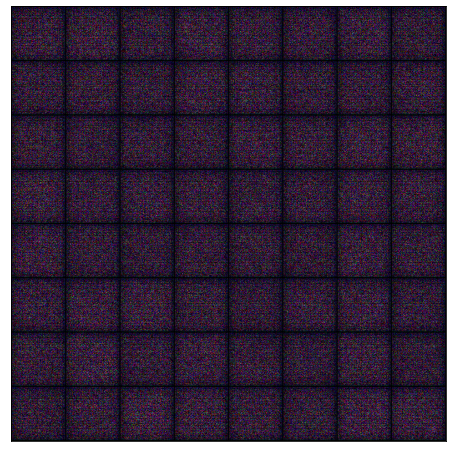

In [22]:
save_images(0, fixed_latent)

In [23]:
# training function
def fit(epochs,lr,start_index=1):
    gc.collect()
    torch.cuda.empty_cache()
    g_losses =[]
    d_losses = []
    real_scores = []
    fake_scores = []

    #optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images,_ in train_dl:
            loss_d,real_score,fake_score = d_train(real_images,opt_d)

            loss_g = g_train(opt_d)
        
        g_losses.append(loss_g)
        d_losses.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch:",epoch+1," loss_g:",loss_g," loss_d:",loss_d," real_score:",real_score)

        save_images(epoch+start_index, fixed_latent,show=False)
    return d_losses,g_losses,fake_scores,real_scores

In [24]:
epochs = 50
lr = 0.004

In [25]:
fit(epochs=epochs,lr=lr)

Epoch: 1  loss_g: 1.3687078952789307  loss_d: 0.8678106665611267  real_score: 0.9470766186714172
Saved:  painter_gan_1.png
Epoch: 2  loss_g: 0.771896481513977  loss_d: 0.6814274787902832  real_score: 0.9975079894065857
Saved:  painter_gan_2.png
Epoch: 3  loss_g: 0.6966942548751831  loss_d: 0.7260875105857849  real_score: 0.9980828166007996
Saved:  painter_gan_3.png
Epoch: 4  loss_g: 0.7548553943634033  loss_d: 0.6622704267501831  real_score: 0.9997526407241821
Saved:  painter_gan_4.png
Epoch: 5  loss_g: 0.6987152099609375  loss_d: 0.7422780990600586  real_score: 0.9994422197341919
Saved:  painter_gan_5.png
Epoch: 6  loss_g: 0.69110107421875  loss_d: 0.6742730736732483  real_score: 0.9995008707046509
Saved:  painter_gan_6.png


KeyboardInterrupt: 